<a href="https://colab.research.google.com/github/Akuu269/PageRank_Method/blob/main/Assignment_4_PageRank_Power_Method_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Docstring : PageRank Power Method

Compute PageRank using the power method from an input .mat file containing
a connectivity matrix G (dense or sparse) and an optional list of URLs U.

Features:
 - Implements the function PageRank(U, G, p) returning (x, urls, info).
 - Accepts both dense numpy arrays and SciPy sparse matrices from MATLAB .mat files.
 - Automatically unwraps MATLAB cell/object arrays for URLs.
 - Builds a column-stochastic Google matrix and correctly handles dangling nodes.
 - Runs the PageRank power method for several teleport probabilities p
   (default: [0.60, 0.75, 0.85, 0.95]) to study sensitivity of PageRank scores.

Console Output:
 - Prints the top-K URLs for each p value.
 - Displays convergence statistics (iteration count, dangling nodes).
 - Provides brief automated comments describing PageRank concentration
   (top-5 mass) and how p affects ranking behavior.

Outputs (saved under './results/'):
   * spy_G.png
         Spy plot of the adjacency/link structure of G.
   * pagerank_sorted_p{p*100}.png
         Bar plot of PageRank values sorted in descending order (per p).
   * pagerank_original_p{p*100}.png
         Bar plot of PageRank values in original node index order (per p).
   * pagerank_top_{p*100}.csv
         CSV file containing the top-K URLs/pages and their PageRank scores (per p).

Notebook / Colab Usage:
 - Plots can be viewed inline using plt.show() or by displaying the saved PNG files.
 - CSV files can be viewed using pandas (pd.read_csv) or displayed directly in the notebook.

In [50]:
import os
import numpy as np
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
import pandas as pd

In [51]:
# -------------------------
# User-configure
# -------------------------

MAT_FILE = "/content/IndianTourism.mat"
P_DEFAULT = 0.85
P_VALUES = [0.6, 0.75, 0.85, 0.95]   # values to compare (includes 0.85)
TOL = 1e-8
MAX_ITER = 1000
TOP_K = 20
OUT_DIR = "./results"
os.makedirs(OUT_DIR, exist_ok=True)


In [52]:
def unwrap_mat_array(X):
    """
    Unwrap MATLAB cell/object arrays loaded by scipy.io.loadmat.
    Keeps unwrapping until a numeric ndarray is found.
    """
    out = X
    while isinstance(out, np.ndarray) and out.dtype == object and out.size == 1:
        out = out.item()
    return out

In [53]:
def load_mat(mat_path):
    """
    Load .mat and return (G, U).
    Accepts dense ndarray OR scipy sparse matrix (coo/csr/csc) stored in the .mat.
    """
    mat = scipy.io.loadmat(mat_path)
    keys = [k for k in mat.keys() if not k.startswith("__")]
    print("MAT keys found:", keys)

    # Prefer common key 'G'
    if "G" not in mat:
        raise ValueError("G not found in MAT file.")
    G = mat["G"]
    G = unwrap_mat_array(G)

    # If G was stored as a scipy.sparse matrix in the .mat it may be already a sparse object.
    # Accept these types: numpy.ndarray or scipy.sparse.spmatrix
    if isinstance(G, np.ndarray):
        # ensure 2-D numeric
        if G.ndim != 2:
            raise ValueError(f"Loaded dense G has ndim={G.ndim}; expected 2.")
        # convert to sparse for downstream operations
        G_sp = sp.csc_matrix(G)
    elif sp.issparse(G):
        # Some MATLAB exports include sparse as coo_matrix etc. Convert to csc for column ops.
        G_sp = G.tocsc()
    else:
        # sometimes matlab stores custom objects -> try to unwrap more and re-check
        # attempt a final unwrap
        G2 = unwrap_mat_array(G)
        if isinstance(G2, np.ndarray):
            G_sp = sp.csc_matrix(G2)
        elif sp.issparse(G2):
            G_sp = G2.tocsc()
        else:
            raise ValueError(f"Unwrapped G has invalid type/shape: {type(G)} {getattr(G,'shape',None)}")

    # U (URLs) optional
    U = mat.get("U", None)
    if U is not None:
        U = unwrap_mat_array(U)

    return G_sp, U


In [54]:
def normalize_urls(U, n):
    """
    Return list of n strings; generate fallback labels if missing.
    """
    if U is None:
        return [f"index_{i}" for i in range(n)]
    arr = np.array(U).reshape(-1)
    urls = []
    for item in arr:
        if isinstance(item, str):
            urls.append(item)
        else:
            try:
                s = np.array(item).astype(str)
                found = None
                for x in s.flat:
                    if str(x).strip():
                        found = str(x)
                        break
                urls.append(found if found is not None else str(item))
            except Exception:
                urls.append(str(item))
    if len(urls) < n:
        urls += [f"index_{i}" for i in range(len(urls), n)]
    return urls[:n]

In [55]:
def build_column_stochastic_M_from_G(G_sp):
    """
    G_sp: scipy.sparse.csc_matrix (columns denote outlinks j -> rows i)
    Returns M (column-stochastic csc), out_deg (array), dangling mask (bool array)
    """
    # ensure CSC
    if not sp.issparse(G_sp):
        G_sp = sp.csc_matrix(G_sp)
    else:
        G_sp = G_sp.tocsc()

    n = G_sp.shape[0]
    out_deg = np.array(G_sp.sum(axis=0)).reshape(-1)   # column sums
    # normalize nonzero columns
    G_coo = G_sp.tocoo()
    rows, cols, data = [], [], []
    for i, j, v in zip(G_coo.row, G_coo.col, G_coo.data):
        dj = out_deg[j]
        if dj > 0:
            rows.append(i); cols.append(j); data.append(v / dj)
    M = sp.csc_matrix((data, (rows, cols)), shape=(n, n))
    dangling = (out_deg == 0)
    return M, out_deg, dangling

In [56]:
def pagerank_power_method(M, dangling_mask, p=0.85, tol=1e-8, max_iter=1000):
    """
    Compute PageRank vector x using power method for column-stochastic M.
    Uses teleportation and distributes dangling mass uniformly.
    Returns vector x (sums to 1) and iteration count.
    """
    n = M.shape[0]
    x = np.ones(n) / n
    teleport = (1.0 - p) / n
    dangling = dangling_mask.astype(float)

    for k in range(max_iter):
        Mx = M.dot(x)                    # shape (n,)
        dangling_sum = x.dot(dangling)   # scalar: mass from dangling columns
        x_new = p * (Mx + dangling_sum / n) + teleport
        err = np.linalg.norm(x_new - x, 1)
        x = x_new
        if err < tol:
            return x / x.sum(), k+1
    # if reached here, not converged within max_iter
    return x / x.sum(), max_iter

In [57]:
def PageRank(U, G_sp, p=0.85, tol=TOL, max_iter=MAX_ITER):
    """
    Signature required by assignment: PageRank(U, G, p)
    Accepts G_sp as scipy sparse csc_matrix.
    """
    n = G_sp.shape[0]
    urls = normalize_urls(U, n)
    M, out_deg, dangling = build_column_stochastic_M_from_G(G_sp)
    x, iters = pagerank_power_method(M, dangling, p=p, tol=tol, max_iter=max_iter)
    info = {"iters": iters, "n": n, "dangling_count": int(np.count_nonzero(dangling)),
            "out_deg_mean": float(np.mean(out_deg)), "out_deg_max": int(np.max(out_deg))}
    return x, urls, info



###### Console Output:

In [61]:
def run_all_and_save(G_sp, U, p_values=P_VALUES):
    # spy plot
    spy_path = os.path.join(OUT_DIR, "spy_G.png")
    plt.figure(figsize=(6,6))
    plt.spy(G_sp, markersize=1)
    plt.title("spy(G) — link structure (black = link)")
    plt.tight_layout()
    plt.savefig(spy_path)
    plt.close()
    print("Saved spy plot to:", spy_path)

    results = {}
    for p in p_values:
        x, urls, info = PageRank(U, G_sp, p=p)
        df = pd.DataFrame({"index": np.arange(info["n"]), "pagerank": x, "url": urls})
        df_sorted = df.sort_values("pagerank", ascending=False).reset_index(drop=True)
        csv_path = os.path.join(OUT_DIR, f"pagerank_top_{int(p*100)}.csv")
        df_sorted.head(TOP_K).to_csv(csv_path, index=False)
        # sorted bar
        png_sorted = os.path.join(OUT_DIR, f"pagerank_sorted_p{int(p*100)}.png")
        plt.figure(figsize=(10,4))
        plt.bar(np.arange(info["n"]), df_sorted["pagerank"].values)
        plt.title(f"PageRank values sorted (p={p})")
        plt.tight_layout()
        plt.savefig(png_sorted)
        plt.show()
        plt.close()
        # original-order bar
        png_orig = os.path.join(OUT_DIR, f"pagerank_original_p{int(p*100)}.png")
        plt.figure(figsize=(10,4))
        plt.bar(np.arange(info["n"]), df["pagerank"].values)
        plt.title(f"PageRank values (original index order) p={p}")
        plt.tight_layout()
        plt.savefig(png_orig)
        plt.show()
        plt.close()
        top5_mass = float(np.sum(np.sort(x)[-5:]))
        comment = f"p={p}: iters={info['iters']}, dangling={info['dangling_count']}, top5_mass={top5_mass:.4f}"
        print("\n", comment)
        print(df_sorted.head(TOP_K).to_string(index=False))
        results[p] = {"csv": csv_path, "png_sorted": png_sorted, "png_orig": png_orig, "df_sorted": df_sorted, "info": info, "comment": comment}
    return spy_path, results

MAT keys found: ['G', 'U']
Loaded G as sparse with shape: (500, 500)
Saved spy plot to: ./results/spy_G.png


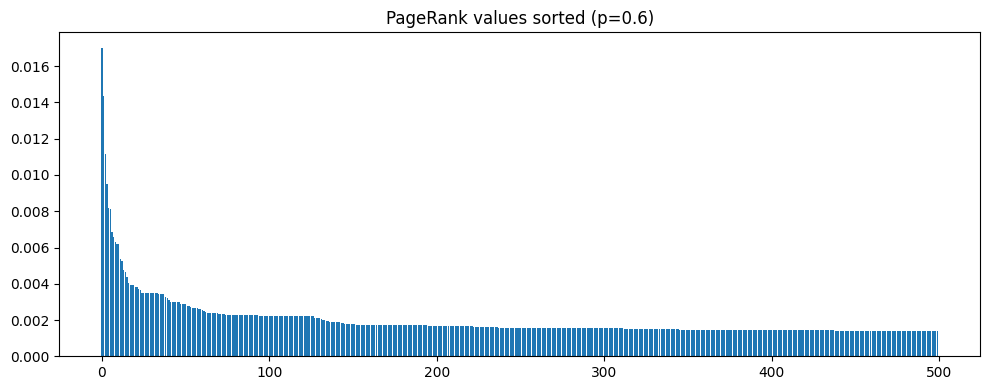

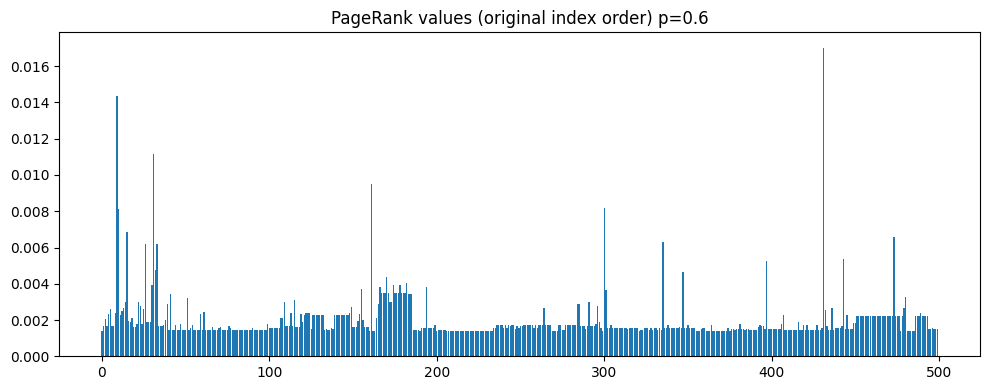


 p=0.6: iters=29, dangling=277, top5_mass=0.0602
 index  pagerank                                            url
   431  0.017018                     http://www.makeinindia.com
     9  0.014354                              http://www.nic.in
    31  0.011159                            http://india.gov.in
   161  0.009505              http://subscribe.businessworld.in
   300  0.008160       http://analytics.wrc.nic.in/cmfanalytics
    10  0.008131                              http://cmf.gov.in
    15  0.006877                             http://drupal.org)
   473  0.006595              http://foodprocessingindia.gov.in
   335  0.006276                         http://pgportal.gov.in
    26  0.006211                           http://nkn.gov.in/en
    33  0.006211                      http://recruitment.nic.in
   443  0.005362                     http://goidirectory.nic.in
   397  0.005249                http://www.makeinindia.com/home
    32  0.004737                           http://gand

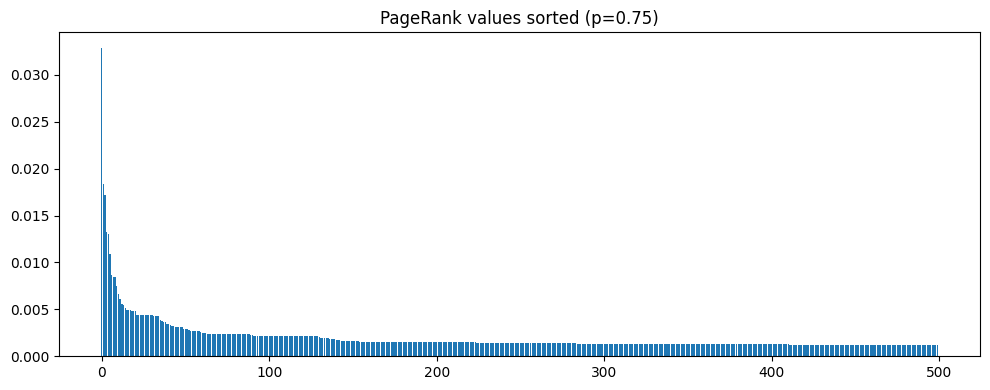

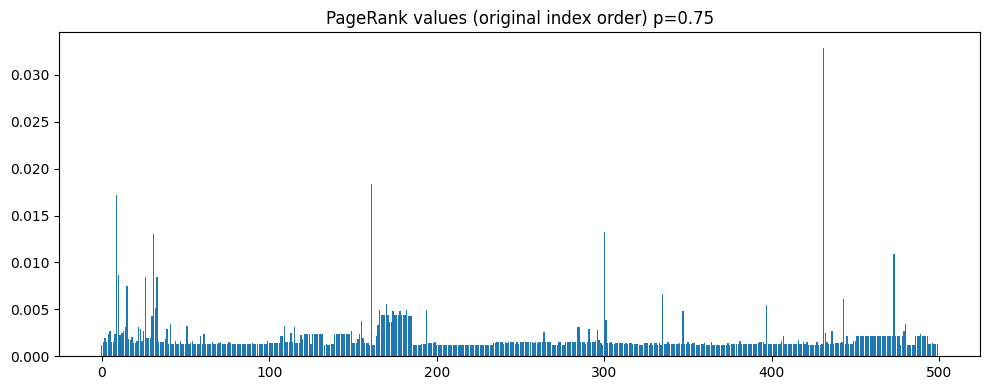


 p=0.75: iters=50, dangling=277, top5_mass=0.0947
 index  pagerank                                            url
   431  0.032895                     http://www.makeinindia.com
   161  0.018384              http://subscribe.businessworld.in
     9  0.017158                              http://www.nic.in
   300  0.013249       http://analytics.wrc.nic.in/cmfanalytics
    31  0.013014                            http://india.gov.in
   473  0.010858              http://foodprocessingindia.gov.in
    10  0.008713                              http://cmf.gov.in
    33  0.008433                      http://recruitment.nic.in
    26  0.008433                           http://nkn.gov.in/en
    15  0.007537                             http://drupal.org)
   335  0.006689                         http://pgportal.gov.in
   443  0.006108                     http://goidirectory.nic.in
   170  0.005527              http://bwdisrupt.businessworld.in
   397  0.005479                http://www.makeinindi

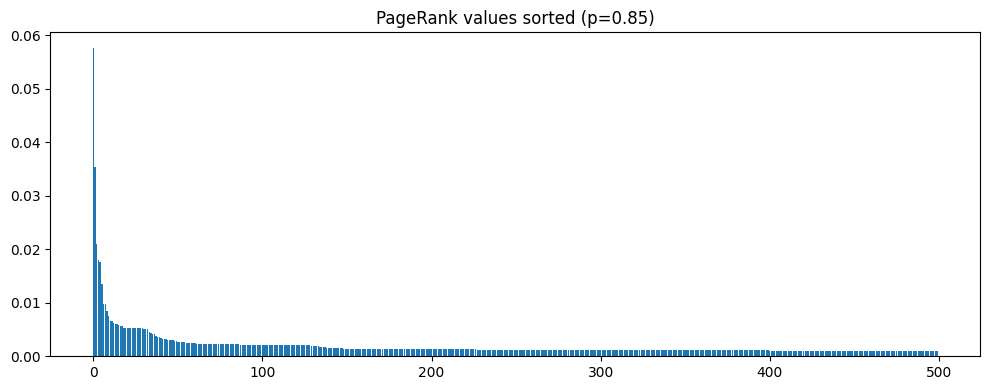

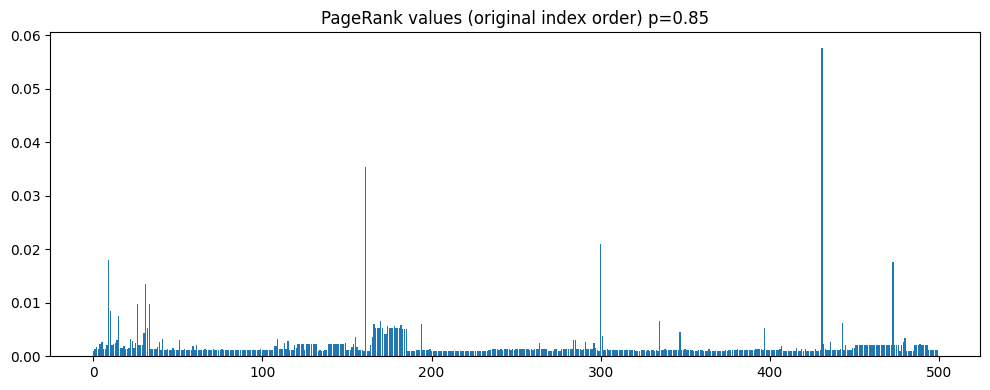


 p=0.85: iters=82, dangling=277, top5_mass=0.1494
 index  pagerank                                                                                                            url
   431  0.057644                                                                                     http://www.makeinindia.com
   161  0.035303                                                                              http://subscribe.businessworld.in
   300  0.020900                                                                       http://analytics.wrc.nic.in/cmfanalytics
     9  0.018004                                                                                              http://www.nic.in
   473  0.017526                                                                              http://foodprocessingindia.gov.in
    31  0.013467                                                                                            http://india.gov.in
    26  0.009677                                     

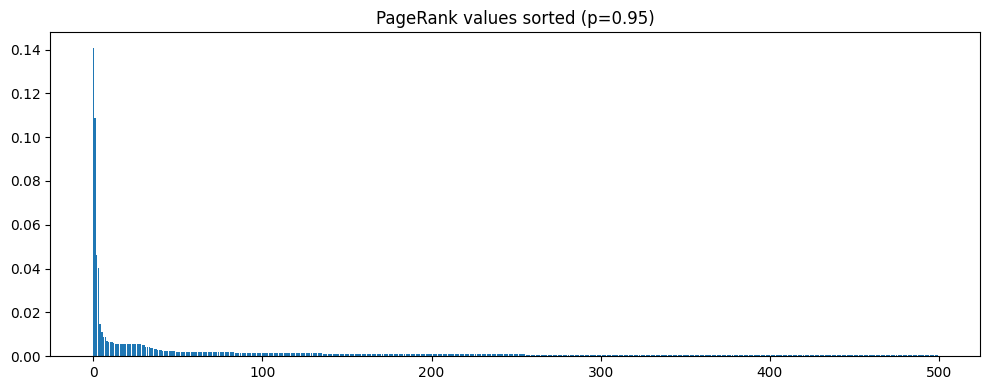

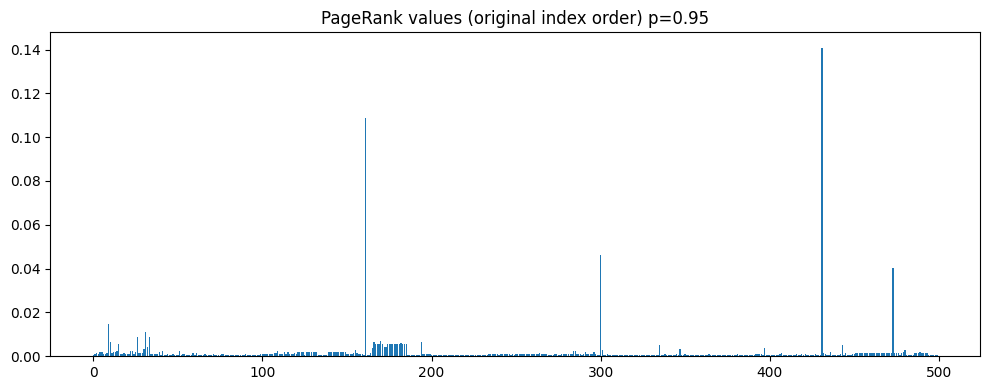


 p=0.95: iters=198, dangling=277, top5_mass=0.3508
 index  pagerank                                                                                                                                                                     url
   431  0.140801                                                                                                                                              http://www.makeinindia.com
   161  0.108806                                                                                                                                       http://subscribe.businessworld.in
   300  0.046288                                                                                                                                http://analytics.wrc.nic.in/cmfanalytics
   473  0.040204                                                                                                                                       http://foodprocessingindia.gov.in
     9  0.014710       

In [62]:
def main():
    if not os.path.exists(MAT_FILE):
        raise FileNotFoundError(f"MAT file not found at {MAT_FILE}")
    G_sp, U = load_mat(MAT_FILE)
    print("Loaded G as sparse with shape:", G_sp.shape)
    spy_path, results = run_all_and_save(G_sp, U)
    print("\nSaved results in:", OUT_DIR)
    return spy_path, results

if __name__ == "__main__":
    main()

#### Outputs (saved under './results/'):

Image: /content/results/pagerank_original_p60.png


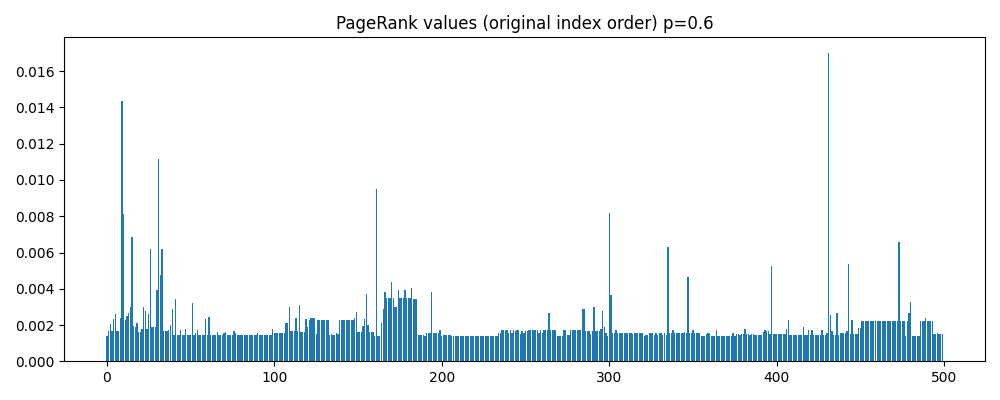

Image: /content/results/pagerank_original_p75.png


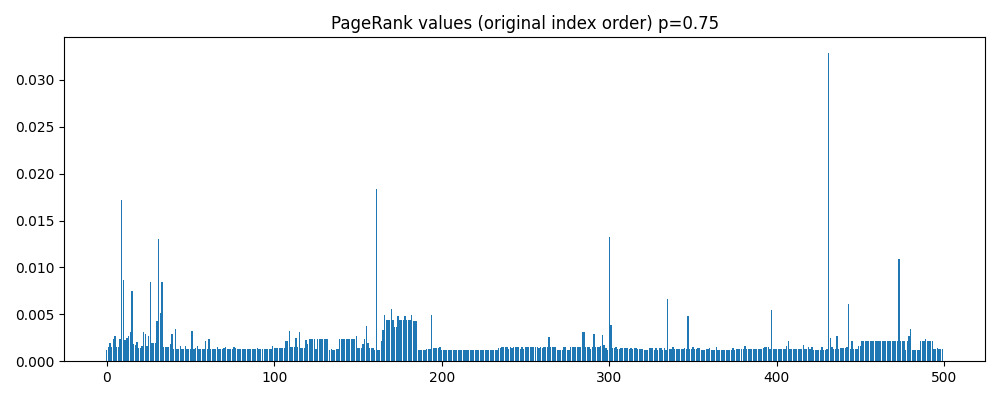

Image: /content/results/pagerank_original_p85.png


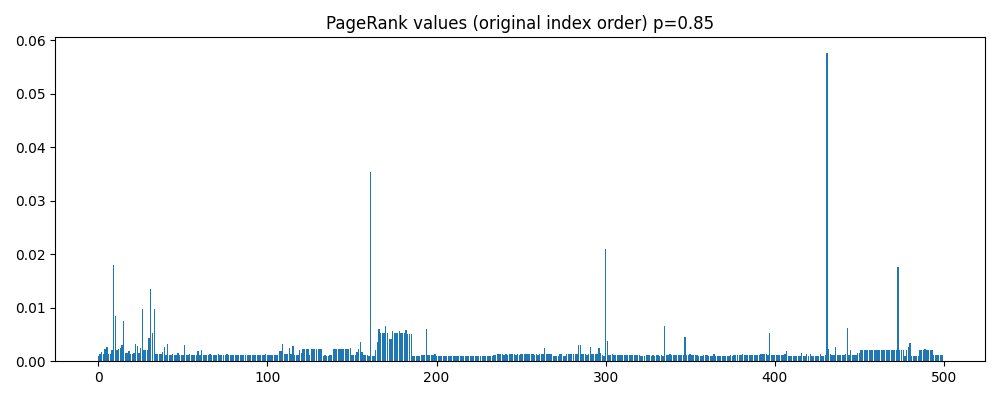

Image: /content/results/pagerank_original_p95.png


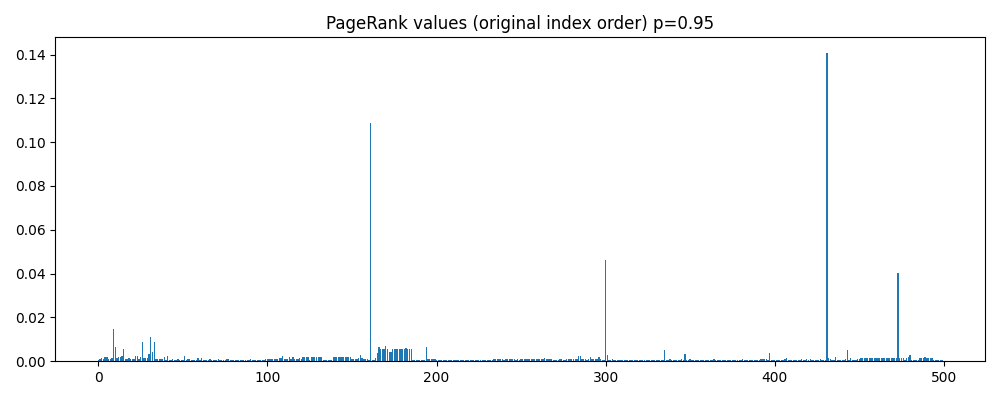

Image: /content/results/pagerank_sorted_p60.png


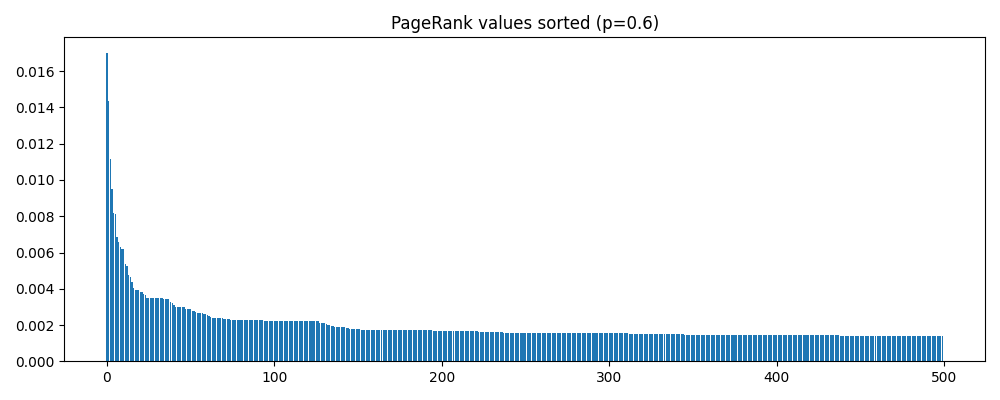

Image: /content/results/pagerank_sorted_p75.png


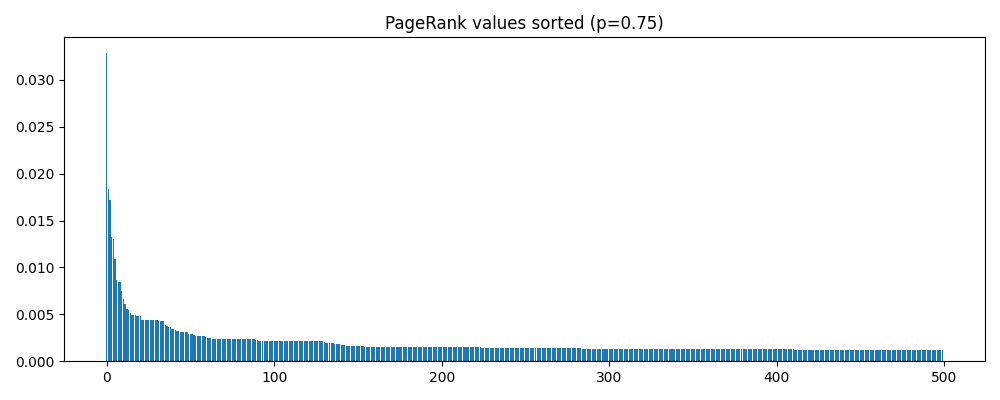

Image: /content/results/pagerank_sorted_p85.png


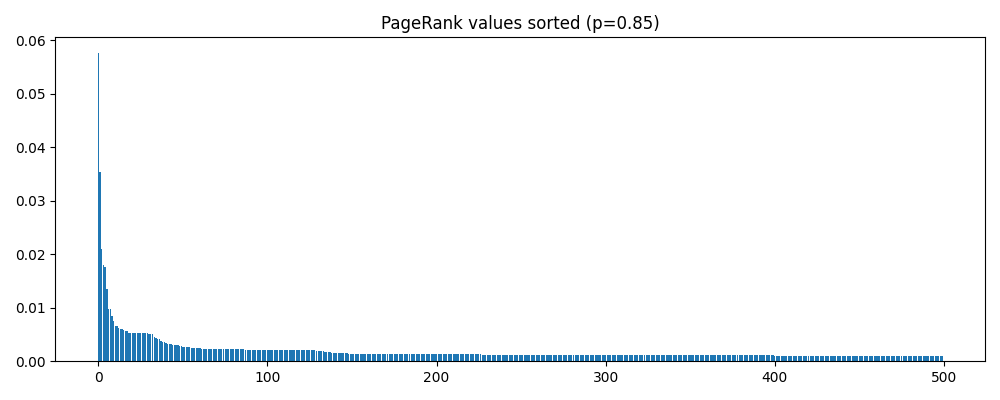

Image: /content/results/pagerank_sorted_p95.png


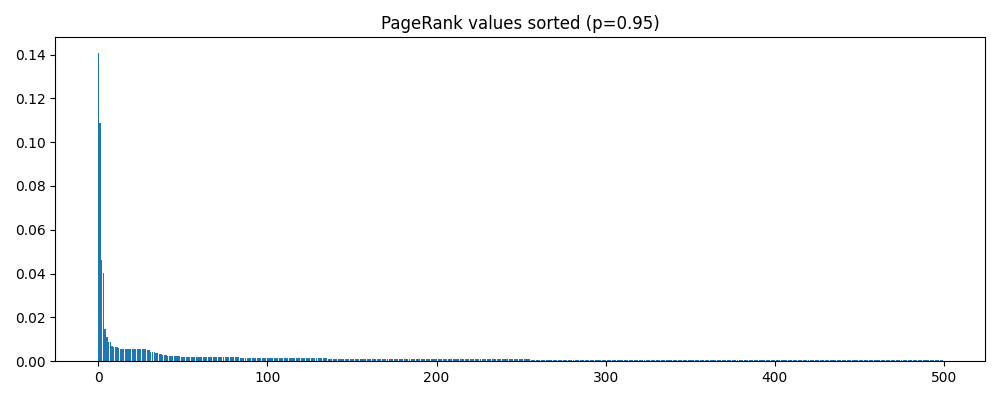

Image: /content/results/spy_G.png


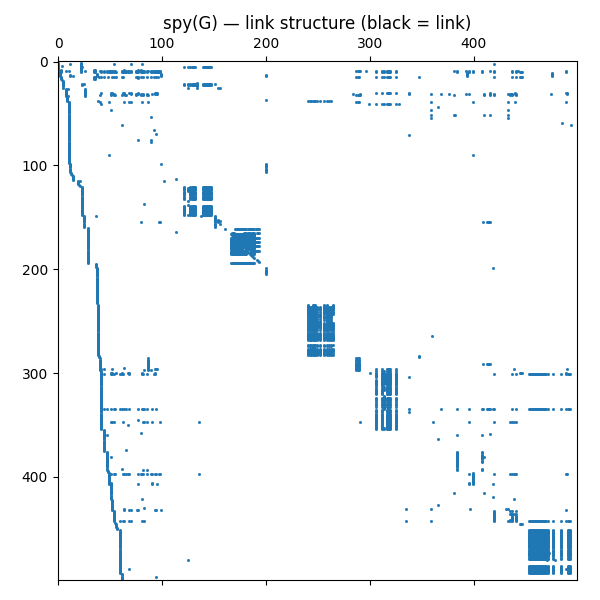


CSV file: /content/results/pagerank_top_60.csv


,index,pagerank,url
0,431,0.017018,http://www.makeinindia.com
1,9,0.014354,http://www.nic.in
2,31,0.011159,http://india.gov.in
3,161,0.009505,http://subscribe.businessworld.in
4,300,0.008160,http://analytics.wrc.nic.in/cmfanalytics



CSV file: /content/results/pagerank_top_75.csv


,index,pagerank,url
0,431,0.032895,http://www.makeinindia.com
1,161,0.018384,http://subscribe.businessworld.in
2,9,0.017158,http://www.nic.in
3,300,0.013249,http://analytics.wrc.nic.in/cmfanalytics
4,31,0.013014,http://india.gov.in



CSV file: /content/results/pagerank_top_85.csv


,index,pagerank,url
0,431,0.057644,http://www.makeinindia.com
1,161,0.035303,http://subscribe.businessworld.in
2,300,0.020900,http://analytics.wrc.nic.in/cmfanalytics
3,9,0.018004,http://www.nic.in
4,473,0.017526,http://foodprocessingindia.gov.in



CSV file: /content/results/pagerank_top_95.csv


,index,pagerank,url
0,431,0.140801,http://www.makeinindia.com
1,161,0.108806,http://subscribe.businessworld.in
2,300,0.046288,http://analytics.wrc.nic.in/cmfanalytics
3,473,0.040204,http://foodprocessingindia.gov.in
4,9,0.014710,http://www.nic.in


In [60]:
import glob
import pandas as pd
from IPython.display import display, Image

for path in sorted(glob.glob("/content/results/*.png")):
    print("Image:", path)
    display(Image(filename=path))

for csv_path in sorted(glob.glob("/content/results/*.csv")):
    print("\nCSV file:", csv_path)
    df = pd.read_csv(csv_path)
    display(df.head())


#### Comment :

The graph is sparse and contains many dangling nodes, which makes PageRank rely more on teleportation. As the teleport probability p increases, the scores become more concentrated on a small set of highly connected or authoritative pages. The spy plot shows clustered linking patterns, and pages at the center of these clusters—such as makeinindia.com and nic.in—consistently receive the highest PageRank. Overall, the structure of the graph and the value of p strongly influence how importance is distributed among the pages.